In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from   scipy.stats import norm
import fsps
import emcee
import corner

# Generate integrated magnitudes using python-fsps

The metallicity of M92 is very low, $[Fe/H]~ -2.15$ which the stellar atmosphere models of Padova, BaSTI and Geneva do not include. In the low metallicity range, PARSEC offers the choice between $[Fe/H]= -2.18$ and $-1.88$ and MIST offers the choice between $[Fe/H] = -2.50$ and $-2.00$. Of these two I decided to use the MIST models. For stellar evolution, I used the default installation of MILES.

The parameters I used to generate the integrated magnitude are:
1. Distance = 8.2kpc
2. Age = 14Gyr
3. [Fe/H] = -2
4. The Cardelli extinction law with Rv = 3.1

In [25]:
def gen_data(filters,sigma):

    print('Initializing Stellar Population..')
    ssp = fsps.StellarPopulation(zmet=2,dust_type=1)
    
    print('Computing magnitude in the V and I bands..')
    mags = ssp.get_mags(tage=14,bands=f)
    mags+= -5 + 5*np.log10(8.2e3) + np.random.normal(loc=0,scale=sigma,size=np.size(f))
    
    return mags

In [4]:
f = [fsps.find_filter('f606w')[1],fsps.find_filter('f814w')[1]]
data = gen_data(f,0.1)

Initializing Stellar Population..
Computing magnitude in the V and I bands..


In [10]:
def lnP(theta,data,ssp,sigma):
    """theta = (zmet,age,distance)"""

    lp = lnprior(theta)
#     print (lp)
    if (np.isfinite(lp)).all() == False:
        return -np.inf
    z,age,dist = lp[0],lp[1],lp[2] 

    mag = ssp.get_mags(zmet=z,tage=age,bands=f)
    mag+= -5 + 5*np.log10(dist*1e3)
    
    d = norm.logpdf(data,loc=mag,scale=sigma)
    return np.sum(d)

In [11]:
def lnprior(theta):
    """theta = (zmet,age,distance)"""
    z,age,dist = theta[0],theta[1],theta[2]
    if 8 < dist < 10:
        if 5 < age < 14:
            if (-2.50 <= z < -2.25):
                return 1,age,dist
            elif (-2.25 <= z <= -2):
                return 2,age,dist
            else:
                return -np.inf, -np.inf, -np.inf
        else:
            return -np.inf, -np.inf, -np.inf
    else:
        return -np.inf, -np.inf, -np.inf

In [12]:
ssp = fsps.StellarPopulation(dust_type=1)
ndim,nwalkers = 3,100
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnP,args=(data,ssp,0.1))

In [13]:
theta0 = np.array([np.random.ranf(ndim) for i in range(nwalkers)])
theta0[:,0] = (-2.5+2)*theta0[:,0]-2.00
theta0[:,1] = (14-5)*theta0[:,1]+5
theta0[:,2] = (10-8)*theta0[:,2]+8

In [14]:
sampler.run_mcmc(theta0,100)

(array([[ -2.44105971,   9.49265615,   9.18027618],
        [ -2.07294492,   9.8625561 ,   8.96846233],
        [ -2.04428422,  11.34345422,   8.68350098],
        [ -2.0124557 ,  11.59079933,   8.60304279],
        [ -2.3600927 ,  10.38032318,   8.70868855],
        [ -2.02859603,  13.42720501,   8.74904862],
        [ -2.01090697,  10.58444816,   8.84668425],
        [ -2.30548174,  10.40896281,   9.00204165],
        [ -2.38268172,   9.23360462,   9.58093557],
        [ -2.09722318,  11.61816271,   8.43471588],
        [ -2.01059244,   8.56622124,   9.80614617],
        [ -2.25175953,  11.83414809,   8.37407703],
        [ -2.23272996,   9.89813382,   9.50651715],
        [ -2.23038824,  12.83351096,   8.85499487],
        [ -2.11128335,  11.39969809,   8.70272412],
        [ -2.40996544,   8.31820225,   9.68950037],
        [ -2.36892795,  10.83980712,   8.54457656],
        [ -2.25025261,   9.73316739,   9.74581296],
        [ -2.33402353,  10.12088582,   9.01365827],
        [ -2

# Results of $\sigma = 0.1$ errors

The metallicity triangle plot looks like expected- since FSPS allows us to vary metallicity only discreetly between $-2.50$ and $-2.00$, there is no convergent value between that range. Distance and age have more convergent values, though they aren't very close to the actual values.

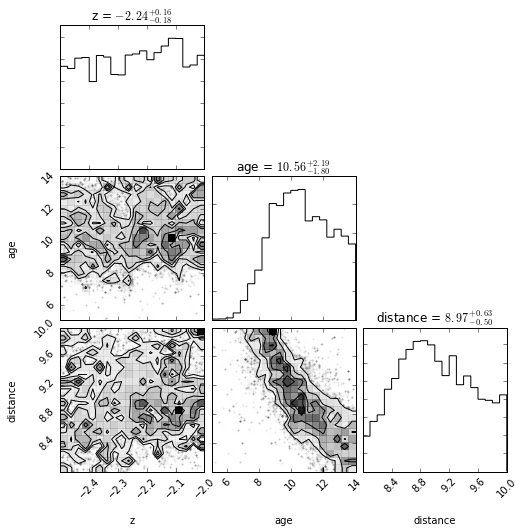

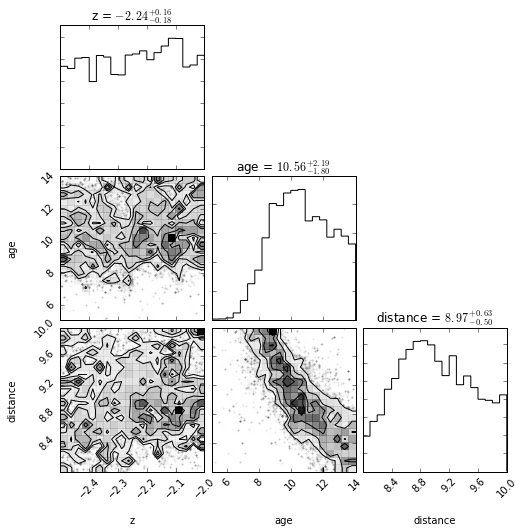

In [15]:
corner.corner(sampler.flatchain,labels=('z','age','distance'),show_titles=True)

# Uncertainity of $\sigma = 0.01$

In [19]:
data = gen_data(f,0.01)

Initializing Stellar Population..
Computing magnitude in the V and I bands..


In [18]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnP,args=(data,ssp,0.01))
sampler.run_mcmc(theta0,100)

(array([[ -2.17059659,  13.82183502,   8.40179056],
        [ -2.1374612 ,  13.01936042,   8.51348796],
        [ -2.16243788,  12.5960758 ,   8.6259945 ],
        [ -2.16865696,  13.15547813,   8.48809607],
        [ -2.12311924,  12.54056576,   8.58054144],
        [ -2.00038179,  13.02567548,   8.53627341],
        [ -2.18447726,  12.03836151,   8.67910297],
        [ -2.11223349,   9.44014513,   9.41337293],
        [ -2.05566774,  11.81775107,   8.7327167 ],
        [ -2.13861607,  11.96110116,   8.69408001],
        [ -2.15947224,   9.6625278 ,   9.25889491],
        [ -2.23692383,   9.65194406,   9.25696039],
        [ -2.05218626,  12.29193745,   8.62344488],
        [ -2.13579545,  12.88367546,   8.57122847],
        [ -2.10316318,   8.41914377,   9.9931004 ],
        [ -2.18595187,  13.81811751,   8.4082827 ],
        [ -2.23044642,  13.42052138,   8.45609633],
        [ -2.05078985,  10.88082198,   8.86162745],
        [ -2.08489889,  13.7694144 ,   8.39647955],
        [ -2

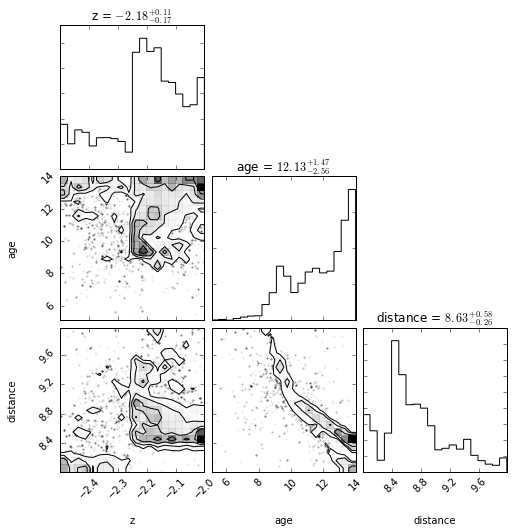

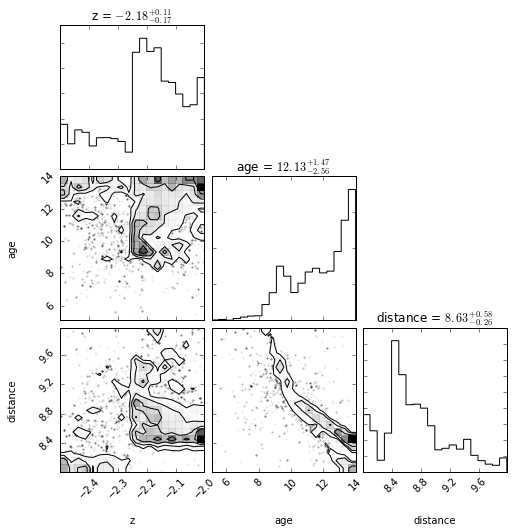

In [17]:
corner.corner(sampler.flatchain,labels=('z','age','distance'),show_titles=True)

# UBVI Filters

In [26]:
f = ['v','u','b','cousins_i']
data = gen_data(f,0.1)

Initializing Stellar Population..
Computing magnitude in the V and I bands..


In [28]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnP,args=(data,ssp,0.1))
sampler.run_mcmc(theta0,100)

(array([[ -2.08222157,   9.69581422,   8.84934356],
        [ -2.42111008,  10.64248374,   8.4399648 ],
        [ -2.05999451,   8.83539587,   9.64795742],
        [ -2.11850483,  12.0153792 ,   8.40106351],
        [ -2.47363767,   7.93942263,   9.47556134],
        [ -2.01946231,  10.2838306 ,   8.51738727],
        [ -2.00416376,   7.65229289,   9.81807339],
        [ -2.47779683,  13.08856601,   8.04905001],
        [ -2.193447  ,  11.50801964,   8.42020914],
        [ -2.16149008,   7.18143634,   9.84988203],
        [ -2.35242381,   7.84761893,   9.37690527],
        [ -2.06803331,   7.51070914,   9.89676311],
        [ -2.16110182,   9.70742483,   8.85823142],
        [ -2.23833889,  12.32724057,   8.1632488 ],
        [ -2.21252975,  10.10781289,   8.86207875],
        [ -2.04477461,   9.64737002,   8.57284567],
        [ -2.39593339,  11.8734117 ,   8.36332849],
        [ -2.35913251,   8.66654353,   9.18690157],
        [ -2.37057914,   9.72138365,   8.53495943],
        [ -2

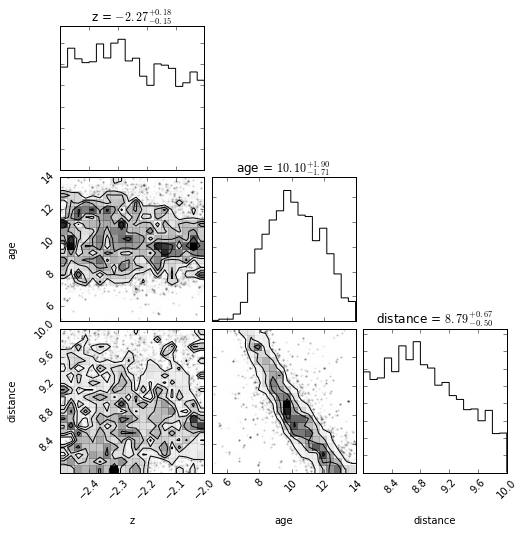

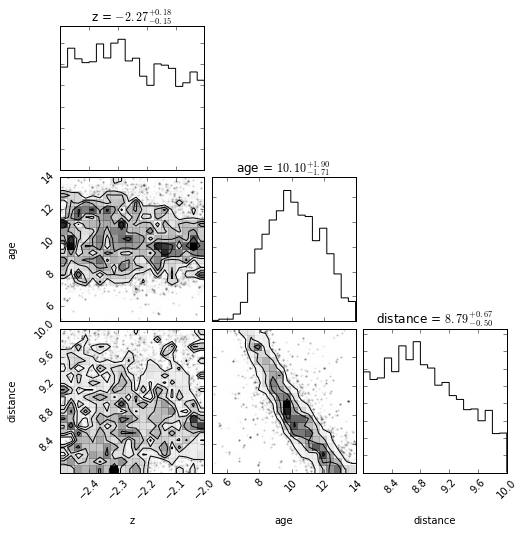

In [29]:
corner.corner(sampler.flatchain,labels=('z','age','distance'),show_titles=True)

# Adding Galex FUV Filter

In [30]:
f = ['v','u','b','cousins_i','galex_fuv']
data = gen_data(f,0.1)

Initializing Stellar Population..
Computing magnitude in the V and I bands..


In [31]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnP,args=(data,ssp,0.1))
sampler.run_mcmc(theta0,100)

(array([[ -2.27764423,   9.75344736,   9.11298279],
        [ -2.43645198,   9.81006982,   8.97707363],
        [ -2.29950015,   9.66677179,   9.13151999],
        [ -2.43973105,   9.98076684,   8.53162477],
        [ -2.30856428,   9.90141762,   8.80732999],
        [ -2.33770758,  10.21568942,   9.20777312],
        [ -2.49766265,  10.16189917,   8.78241525],
        [ -2.2778799 ,   7.01411545,   9.72799576],
        [ -2.43530131,   9.99050944,   8.9894656 ],
        [ -2.28797113,   9.94283326,   8.99538138],
        [ -2.25070099,   9.47867409,   9.10540021],
        [ -2.48063224,   9.97209221,   8.96927511],
        [ -2.42117288,   9.72061337,   9.08761297],
        [ -2.38357461,  10.15243975,   9.0657697 ],
        [ -2.37028321,   9.96543877,   9.17311175],
        [ -2.19385828,  13.87191536,   8.1184117 ],
        [ -2.27300601,   6.99303164,   9.53551634],
        [ -2.49874806,   9.87385515,   9.217517  ],
        [ -2.03289331,  13.68367608,   8.09744085],
        [ -2

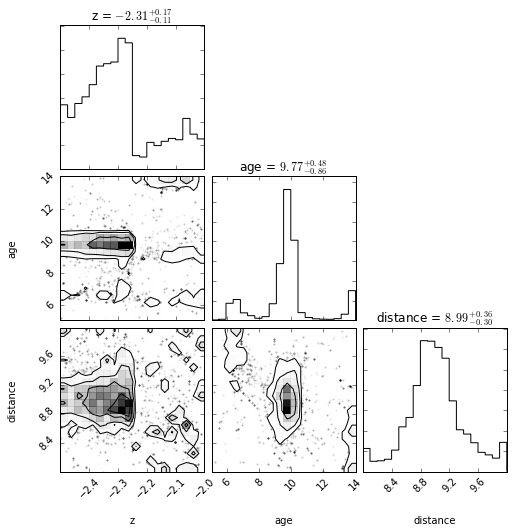

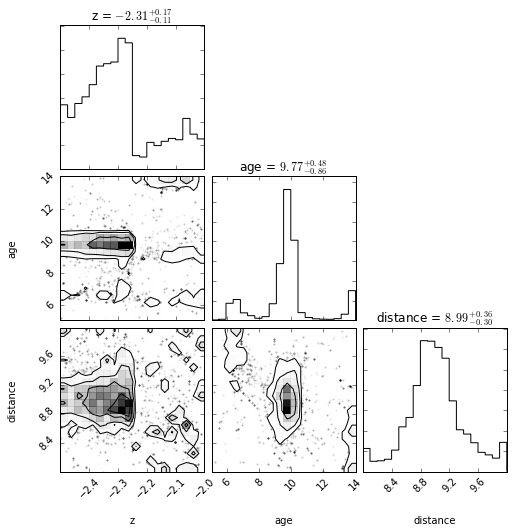

In [32]:
corner.corner(sampler.flatchain,labels=('z','age','distance'),show_titles=True)